In [1]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


In [2]:
def mat2tfr(p_file):
    # converting mat file as numpy
    mat = loadmat(p_file)
    data = mat['dataStruct']['data'][0][0]
    # check if file is mainly zero's (100% dropout)
    if (np.count_nonzero(data) < 10) or (np.any(np.std(data, axis=0) < 0.5)):
        print("WARNING: File %s is all dropout." %p_file)
        return
    
    # getting the filename and retrieving the patient, segement and label data
    pat, seg, label = p_file.split('/')[-1].split('.')[0].split("_")
    filename = pat + "_" + seg + "_" + label + ".tfr"
    fullpathname = "./dataset/" + filename
    print("Converting " + p_file + " ----> " + fullpathname)
    # TensorFlow Records writer
    with tf.python_io.TFRecordWriter(fullpathname) as tfrwriter:
        # Fill protobuff
        protobuf = tf.train.Example(features=tf.train.Features(feature={
                    'data' : tf.train.Feature(float_list=tf.train.FloatList(value=data.flatten().tolist())), 
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)])), 
                    'filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])), 
                }))
        write = tfrwriter.write(protobuf.SerializeToString())
        
        
def dataset(folder, num_files=None):
    # get files
    filenames = glob.glob(folder)
    # randomize read files
    np.random.shuffle(filenames)
    # truncate reading
    if num_files is not None:
        filenames = filenames[:num_files]
    print("Converting #%d files."%len(filenames))
    
    for files in filenames:
        t = time.time()
        mat2tfr(files)
        elapsed = time.time() - t
        print("elapsed: %.3fs"%elapsed)        
        
dataset("./data/train_3/*0.mat", 0)

print('finished')        

Converting #0 files.
finished


Loading #10 files.
(8, 2400, 16)
done


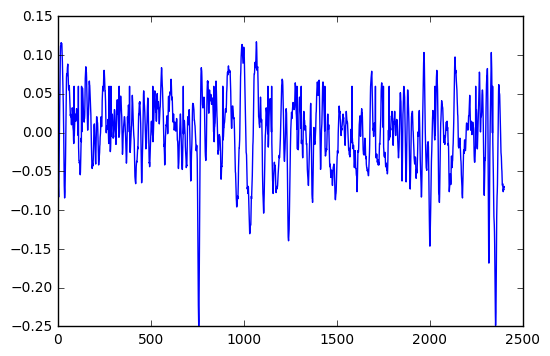

In [30]:
slim = tf.contrib.slim

_SAMPLE_POINTS = 240000
_CHANNELS = 16
_NUM_LABELS = 2
_NUM_SPLITS = 100
_SIGMA_THRESHOLD = 1.0
_BATCH_SIZE = 8

def read_dataset(folder):
    with tf.Graph().as_default():
        filenames = glob.glob(folder)
        print("Loading #%d files."%len(filenames))

        reader = tf.TFRecordReader

        keys_to_features = {
            'data': tf.FixedLenFeature([_SAMPLE_POINTS*_CHANNELS], tf.float32),
            'label': tf.FixedLenFeature([], tf.int64),
            #'filename': tf.FixedLenFeature([], tf.string),
        }
        items_to_handlers = {
            'data': slim.tfexample_decoder.Tensor('data'), 
            'label': slim.tfexample_decoder.Tensor('label'), 
            #'filename': slim.tfexample_decoder.Tensor('filename'), 
        }    
        decoder = slim.tfexample_decoder.TFExampleDecoder(
            keys_to_features, items_to_handlers)

        items_to_descriptions = {
            'data': '240000 sample points of iEEG.',
            'label': 'Label 0 indicates interictal and 1 preictal.', 
            #'filename': 'File name containing the data',
        }

        dataset = slim.dataset.Dataset(
            data_sources=filenames, 
            reader=reader, 
            decoder=decoder, 
            num_samples=1, 
            items_to_descriptions=items_to_descriptions)

        data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, shuffle=False, num_epochs=None, common_queue_capacity=16, common_queue_min=1)

        data, label = data_provider.get(['data', 'label'])
        
        ## Preprocess
        # Split data into smaller segments (speeds up trainning)
        data = tf.reshape(data, shape=[_SAMPLE_POINTS, _CHANNELS])
        data = tf.pack(tf.split(0, _NUM_SPLITS, data), axis=0)
        # Remove dropout segments
        _, var = tf.nn.moments(data, axes=[1, 2])
        # 'tf.where' returns a 2D Tensor. reshape it to 1D.
        idx_clean = tf.reshape(tf.where(tf.greater(var, _SIGMA_THRESHOLD)), shape=[-1])
        # gather from data only indexes > sigma threshold
        data = tf.gather(data, idx_clean)
        # Create label array of segments
        label = tf.one_hot(label, _NUM_LABELS, dtype=tf.int32)
        num_segments = tf.shape(data)[0]
        label = tf.reshape(tf.tile(label, [num_segments]), shape=[num_segments, _NUM_LABELS])
        # Normalize mean=0 and sigma=0.25
        data_mean = tf.expand_dims(tf.reduce_mean(data, reduction_indices=[1]), dim=1)
        data = tf.sub(data, data_mean)
        data_max = tf.expand_dims(tf.reduce_max(tf.abs(data), reduction_indices=[1]), dim=1)
        data = tf.div(data, tf.mul(4.0, data_max))

        # Batch it up.
        data, label = tf.train.shuffle_batch([data, label], 
                                             batch_size=_BATCH_SIZE, 
                                             num_threads=1, 
                                             capacity=20*_BATCH_SIZE, 
                                             min_after_dequeue=6*_BATCH_SIZE, 
                                             enqueue_many=True)

        with tf.Session() as sess:    
            with slim.queues.QueueRunners(sess):
                for i in xrange(1): 
                    dt, lbl = sess.run([data, label])
                    ndt = np.array(dt)
                    print(ndt.shape[:])
                    plt.plot(ndt[0,:,0])

read_dataset('./dataset/*.tfr')
    
print('done')
    

In [ ]:
def plot_eeg(data):
    plt.figure(figsize=(10,20))
    for i in range(0,16):
        plt.subplot(8,2,i+1)
        plt.plot(data[:,i])
    
    #plt.savefig('foo.pdf', bbox_inches='tight')